## 5.3 전이학습

- 이미지넷처럼 아주 큰 데이터셋을 써서 훈련된 모델의 가중치를 가져와 우리가 해결하려는 과제에 맞게 보정해서 사용하는 것을 의미
- 아주 큰 데이터셋을 사용해 훈련된 모델을 사전 훈련된 모델(네트워크)라고 함.
- 문제 A -> (해결) -> 문제 A를 해결하면서 얻은 지식 및 경험 -> (전이 학습) -> 문제 B

### 5.3.1 특성 추출 기법

- 특성 추출은 ImageNet 데이터셋으로 사전 훈련된 모델을 가져온 후 마지막에 완전연결층 부분만 새로 만듦.
- 학습할 때는 마지막 완전연결층만 학습하고 나머지 계층들은 학습되지 않도록 함.
- 특성 추출은 이미지 분류를 위해 두 부분으로 구성됨.
  - 합성곱층: 합성곱층과 풀링층으로 구성
  - 데이터 분류기(완전연결층): 추출된 특성을 입력받아 최종적으로 이미지에 대한 클래스를 분류하는 부분
  - 사용 가능한 이미지 분류 모델: Xception, Inception V3, ResNet50, VGG16, VGG19, MobileNet

In [1]:
!pip install opencv-python

In [2]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
data_path = ('/content/drive/MyDrive/dnn/chap05/data/catanddog/train')

In [17]:
transform = transforms.Compose(
    [
        transforms.Resize([256,256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

385


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


1. torchvision.transform은 이미지 데이터를 변환하여 모델(네트워크)의 입력으로 사용할 수 있게 변환해줌.
 - Resize: 이미지 크기 조정
 - RandomResizedCrop: 이미지를 랜덤한 크기 및 비율로 자름.
 - RandomHorizontalFlip: 이미지를 랜덤하게 수평으로 뒤집음.
 - ToTensor: 이미지 데이터를 텐서로 변환함.

2. datasets.ImageFolder는 데이터로더가 데이터를 불러올 대상(혹은 경로)과 방법(혹은 전처리)을 정의
  - 첫 번째 파라미터: 불러올 데이터가 위치한 경로
  - transform: 이미지 데이터에 대한 전처리

3. 데이터로더는 데이터를 불러오는 부분으로 앞에서 정의한 ImageFolder(train_datset)을 데이터로더에 할당, 이때 한 번에 불러올 데이터양을 결정하는 batch_size를 지정.
  
  - 첫 번째 파라미터: 데이터셋을 지정
  - batch_size: 한 번에 불러올 데이터양을 결정하는 배치 크기 설정
  - num_workers: 데이터를 불러올 때 하위 프로세스를 몇 개 사용할지 설정.
  - shuffle: 데이터를 무작위로 섞을지를 지정. shuffle=True로 설정하면 데이터를 무작위로 섞어 랜덤으로 불러옴.

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


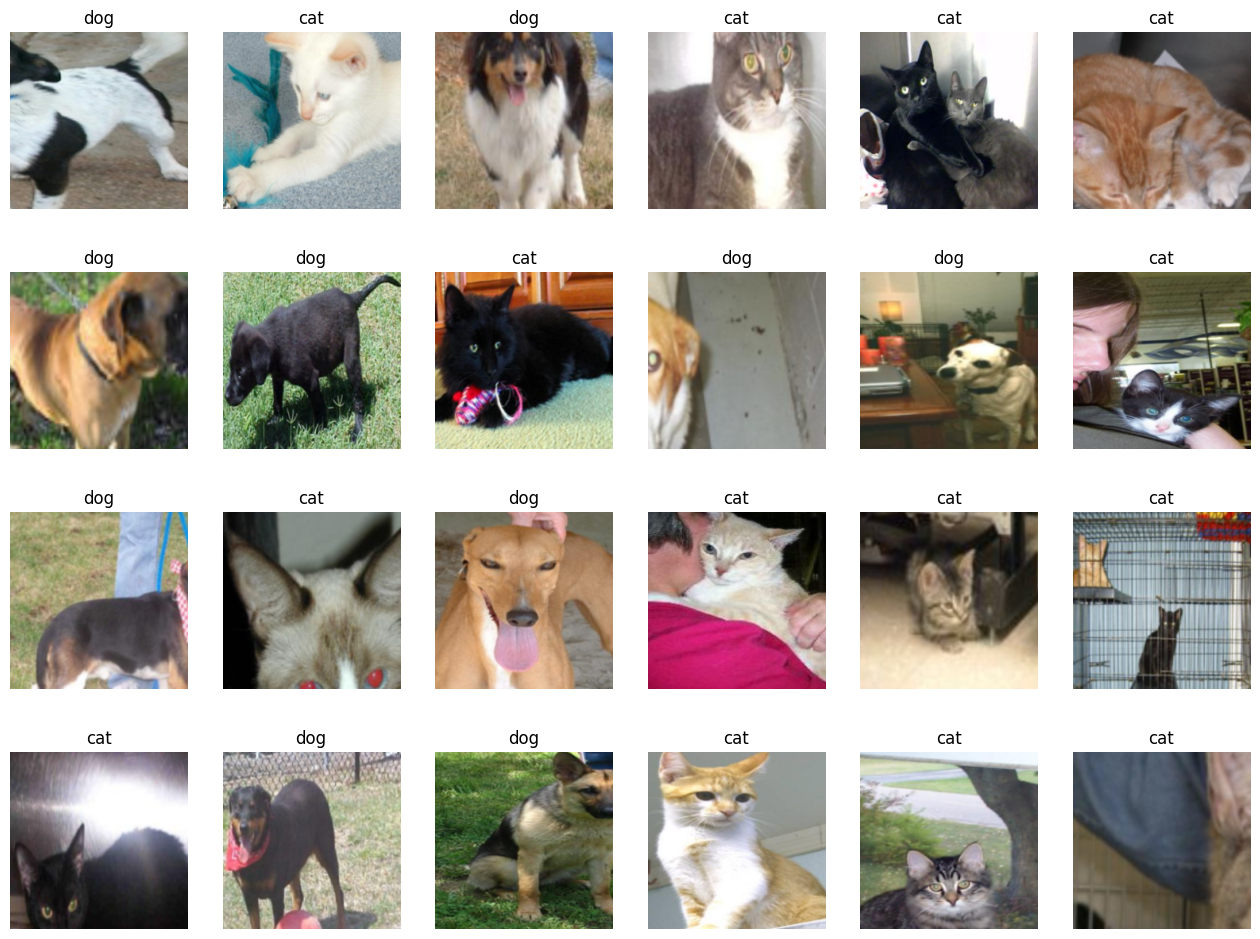

In [19]:
# 학습에 사용될 이미지 출력

import numpy as np
samples, labels = next(iter(train_loader))
classes = {0:'cat', 1:'dog'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))

plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

1. 반복자(iterator, for 구문과 같은 효과)를 사용하려면 iter()와 next()가 필요
  - iter()는 전달된 데이터의 반복자를 꺼내 반환
  - next()는 그 반복자가 다음에 출력해야 할 요소를 반환

2. np.transpose는 행과 열을 바꿈으로써 행렬의 차원을 바꿔 줌.
  - ex) np.transpose(samples[i].numpy(), (1,2,0))을 사용해 변환.

In [20]:
# 사전 훈련된 모델 내려받기

resnet18 = models.resnet18(pretrained=True)
# pretrained=True는 사전 학습된 가중치를 사용하겠다는 의미

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
# 사전 훈련된 모델의 파라미터 학습 유무 지정
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

set_parameter_requires_grad(resnet18)

- param.requires_grad = False 는 역전파 중 파라미터들에 대한 변화를 계산할 필요가 없음을 나타냄.

In [22]:
# ResNet18에 완전연결층 추가

resnet18.fc = nn.Linear(512,2)

In [25]:
# 모델의 파라미터 값 확인

for name, param in resnet18.named_parameters():
  if param.requires_grad:
    print(name, param.data)

fc.weight tensor([[-0.0178, -0.0050,  0.0386,  ..., -0.0162,  0.0185,  0.0426],
        [ 0.0346, -0.0265,  0.0199,  ...,  0.0024,  0.0283,  0.0282]])
fc.bias tensor([0.0259, 0.0120])


In [28]:
# 모델 객체 생성 및 손실 함수 정의
model = models.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

model.fc = torch.nn.Linear(512,2)

for param in model.fc.parameters():
  param.requires_grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
# 모델 학습을 위한 함수 생성

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13,
                is_train=True):
  since = time.time()
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-'*10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()
      running_corrects += torch.sum(preds==labels.data)

    epoch_loss = running_loss/len(dataloaders.dataset)
    epoch_acc = running_corrects.double()/len(dataloaders.dataset)

    print('Loss:{:.4f} Acc:{:.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())
    loss_history.append(epoch_loss)
    torch.save(model.state_dict(),
               os.path.join('/content/drive/MyDrive/dnn/chap05/data/catanddog/''{0:0=2d}.pth'.format(epoch)))
    print()

  time_elapsed = time.time()
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                      time_elapsed % 60))
  print('Best ACC: {:.4f}'.format(best_acc))
  return acc_history, loss_history

In [47]:
# 파라미터 학습 결과를 옵티마이저에 전달

params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param)
    print("\t", name)

optimizer = optim.Adam(params_to_update)

	 fc.weight
	 fc.bias


In [48]:
# 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

Epoch 0/12
----------
Loss:0.0128 Acc:0.8961

Epoch 1/12
----------
Loss:0.0104 Acc:0.8909

Epoch 2/12
----------
Loss:0.0081 Acc:0.9039

Epoch 3/12
----------
Loss:0.0085 Acc:0.9299

Epoch 4/12
----------
Loss:0.0082 Acc:0.9506

Epoch 5/12
----------
Loss:0.0081 Acc:0.9091

Epoch 6/12
----------
Loss:0.0099 Acc:0.9065

Epoch 7/12
----------
Loss:0.0074 Acc:0.9091

Epoch 8/12
----------
Loss:0.0089 Acc:0.9221

Epoch 9/12
----------
Loss:0.0087 Acc:0.9325

Epoch 10/12
----------
Loss:0.0060 Acc:0.9299

Epoch 11/12
----------
Loss:0.0078 Acc:0.9143

Epoch 12/12
----------
Loss:0.0094 Acc:0.8987

Training complete in 29399336m 39s
Best ACC: 0.9506


In [53]:
# 테스트 데이터 호출 및 전처리

test_path = ('/content/drive/MyDrive/dnn/chap05/data/catanddog/test')

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

98


In [59]:
# 테스트 데이터 평가 함수 생성

def eval_model(model, dataloaders, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('/content/drive/MyDrive/dnn/data/chap05/data/catanddog/'+'*.pth')
  saved_models.sort()
  print('saved_model', saved_models)

  for model_path in saved_models:
    print('Loading model', model_path)

    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad():
        outputs = model(inputs) # 'models(inputs)' 대신 'model(inputs)'으로 수정

      _, preds = torch.max(outputs.data, 1)
      preds[preds>=0.5] = 1
      preds[preds< 0.5] = 0
      running_corrects += preds.eq(labels.cpu()).int().sum()

    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Acc: {:.4f}'.format(epoch_acc))

    if epoch_acc > best_acc:
      best_acc = epoch_acc
      acc_history.append(epoch_acc.item())
      print()

    time_elapsed = time.time() - since
    print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed//60,
                                                          time_elapsed % 60))
    print('Best ACC: {:.4f}'.format(best_acc))

    return acc_history

1. glob은 현재 디렉터리에서 원하는 파일들만 추출해 가져올 때 사용.
2. torch.max는 주어진 텐서 배열의 최댓값이 들어 있는 Index를 반환하는 함수
3. preds.eq(labels)는 preds 배열과 labels가 일치하는지 검사하는 용도로 사용.

In [60]:
# 테스트 데이터를 평가 함수에 적용
val_acc_hist = eval_model(resnet18, test_loader, device)

saved_model []


ValueError: x, y, and format string must not be None

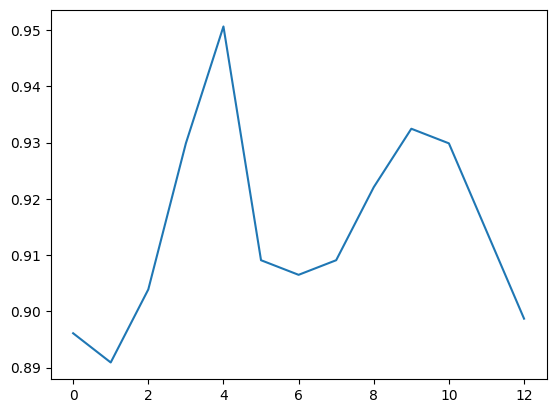

In [61]:
# 훈련과 테스트 데이터의 정확도를 그래프로 확인
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

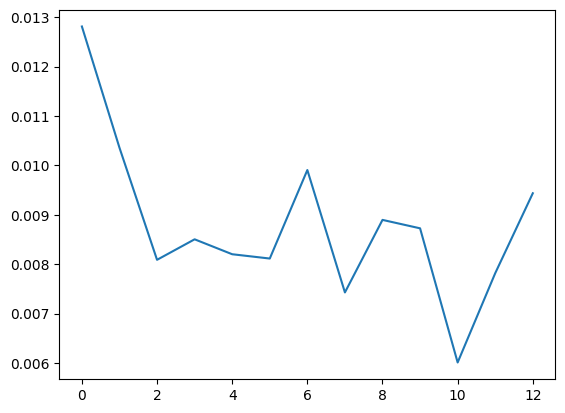

In [62]:
# 훈련 데이터의 오차에 대한 그래프 확인
plt.plot(train_loss_hist)
plt.show()

In [63]:
# 예측 이미지 출력을 위한 전처리 함수
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5)))
  image = image.clip(0,1)
  return image

1. tensor.clone()은 기존 텐서의 내용을 복사한 텐서를 생성하겠다는 의미, detach()는 기존 텐서에서 기울기가 전파되지 않는 텐서

- tensor.clone() - 새롭게 할당 - 계산 그래프에 계속 상주
- tensor.detach() - 공유해서 사용 - 계산 그래프에 상주하지 않음
- tensor.clone.detach() - 새롭게 할당 - 계산 그래프에 상주하지 않음

2. clip()은 입력 값이 주어진 범위를 벗어날 때 입력 값을 특정 범위로 제한시키기 위해 사용. 즉, image.clip(0,1)은 image 데이터를 0과 1 사이의 값으로 제한하겠다는 의미.

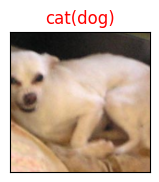

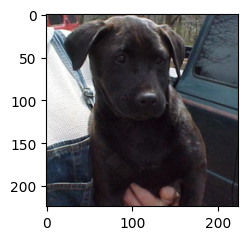

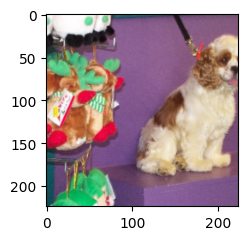

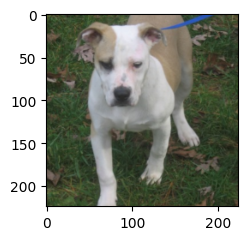

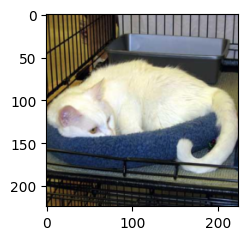

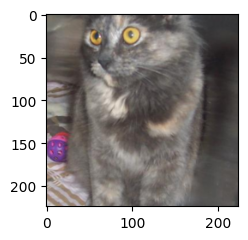

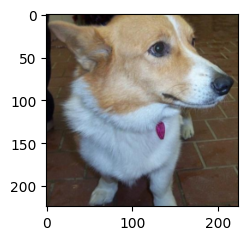

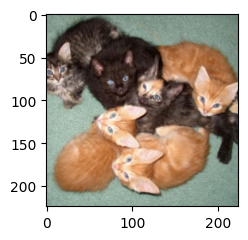

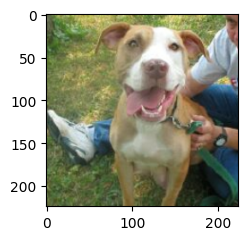

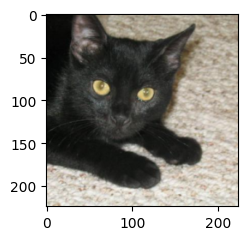

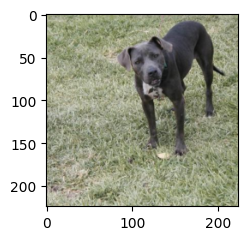

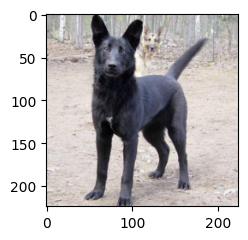

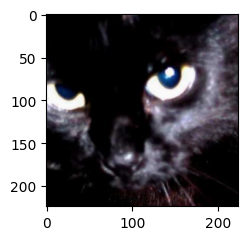

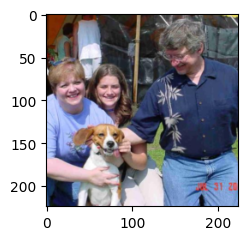

In [ ]:
# 개와 고양이 에측 결과 출력

classes = {0:'cat', 1:'dog'}

daiter = iter(test_loader)
images, labels = next(daiter)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(f"{classes[labels[idx].item()]}")
  ax.set_title(f"{str(classes[preds[idx].item()])}({str(classes[labels[idx].item()])})",
               color=('green' if preds[idx]==labels[idx] else 'red'))
  plt.show()
  plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

1. add_subplot은 한 화면에 여러 개의 이미지를 담기 위해 사용.
  - 첫 번째 파라미터: 행의 수 의미
  - 두 번째 파라미터: 열의 수
  - 세 번째 파라미터: 인덱스를 의미, 행과 열을 기준으로 순차적으로 이미지 출력
  - 네 번째 파라미터: 틱(tick)을 삭제하겠다는 의미

2. classes[preds[idx].item()]은 preds[idx].item() 값이 classes로 정의된 '0'과 '1' 중 어떤 값을 갖는지 판별하겠다는 의미

3. Figure 안에서 서브플롯의 위치를 조정할 때 사용.

### 5.3.2 미세 조정 기법

- 특성 추출 기법에서 더 나아가 사전 훈련된 모델과 합성곱층, 데이터 분류기의 가중치를 업데이트하여 훈련시키는 방식
- 사전 훈련된 네트워크를 미세 조정해 분석하려는 데이터셋에 잘 맞도록 모델의 파라미터를 조정하는 기법
  - 데이터셋이 크고 사전 훈련된 모델과 유사성이 작을 경우: 모델 전체를 재학습시킴.
  - 데이터셋이 크고 사전 훈련된 모델과 유사성이 클 경우: 합성곱층의 뒷부분과 데이터 분류기를 학습시킴. 데이터셋이 유사하기 때문에 전체를 학습시키는 것 보다 강한 특징이 나타나는 합성곱층의 뒷부분과 데이터 분류김나 새로 학습하더라도 최적의 성능을 낼 수 있음.
  - 데이터세싱 작고 사전 훈련된 모델과 유사성이 작을 경우: 합성곱층의 일부분과 데이터 분률기를 학습시킴. 데이터가 적기 때문에 일부 계층에 미세 조정 기법을 적용한다고 해도 효과가 없ㅇ르 수 있음.
  - 데이터셋이 작고 사전 훈련된 모델과 유사성이 클 경우: 데이터 분류기만 학습시킴. 데이터가 적기 때문에 많은 계층에 미세 조정 기법을 적용하면 과적합이 발생할 수 있음.

- 미세 조정은 파라미터 업데이터 과정에서 파라미터에 큰 변화를 주게 되면 과적합 문제가 발생할 수 있기 때문에 정교하고 미세한 파라미터 업데이트가 필요